In [1]:
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)



In [10]:
engine.execute('SELECT * FROM Station LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [11]:
engine.execute('SELECT * FROM Measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

('2017-08-23',)
2016-08-23


<IPython.core.display.Javascript object>


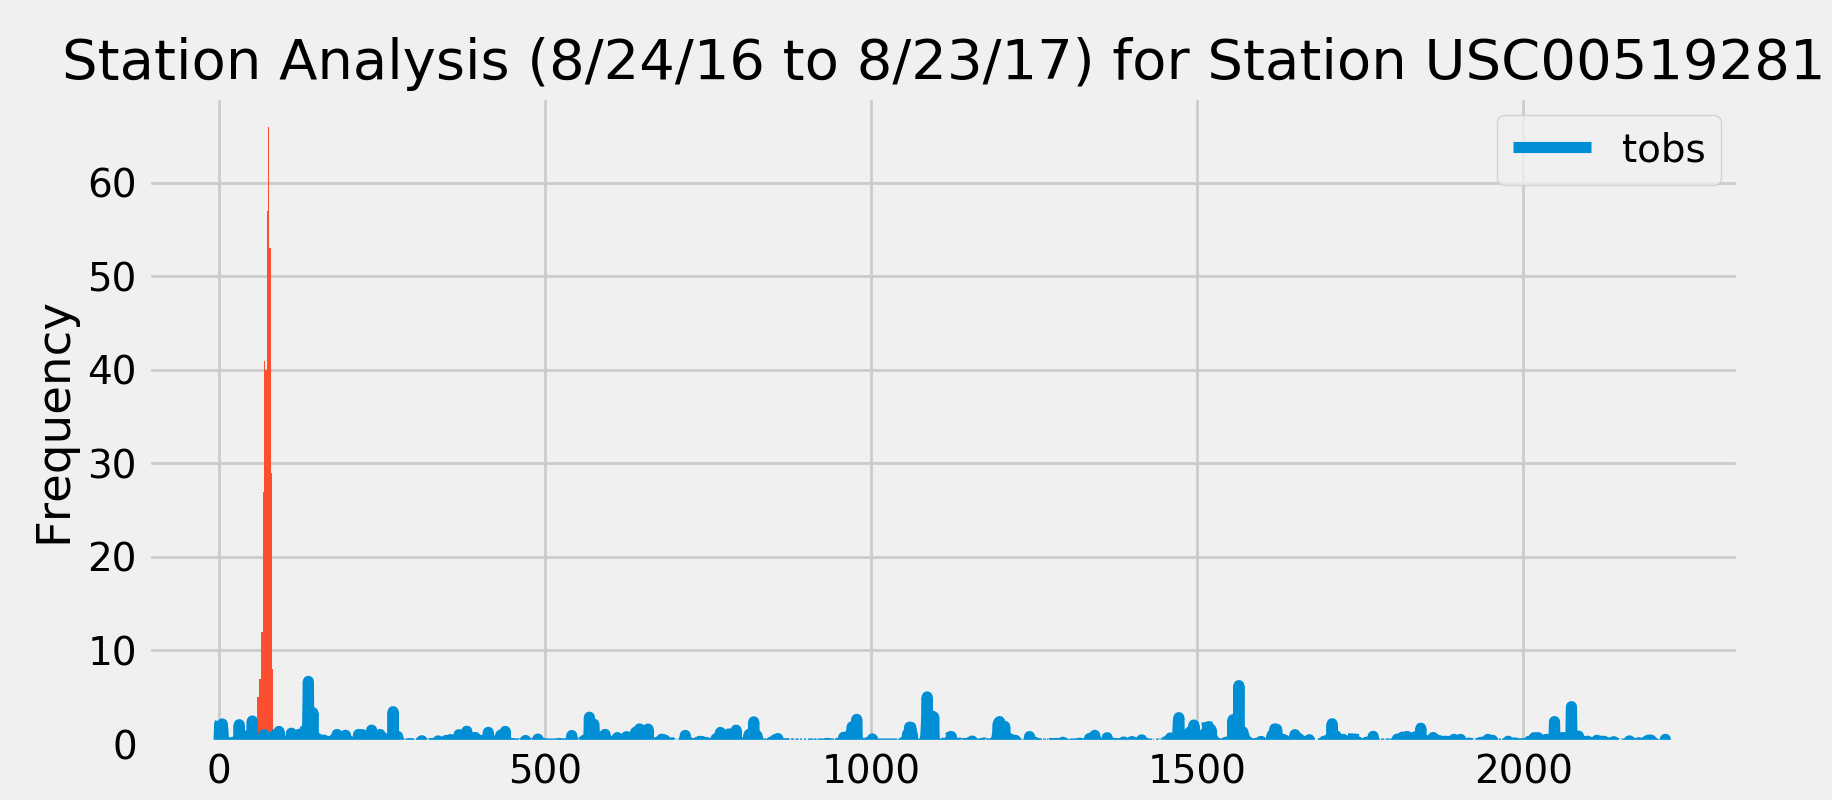

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date)
# Calculate the date 1 year ago from today
one_year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(one_year_ago)


# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_data_df = pd.DataFrame(prcp_data)
prcp_data_df.head()

# Sort the dataframe by date
prcp_data_df.set_index('date').head()

ax = prcp_data_df.plot(figsize=(8,4))
ax.set_title("Precipitation Analysis (8/24/16 to 8/23/17)")
ax.set_ylabel('frequency')
plt.show()




In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [14]:
# How many stations are available in this dataset?
locations = session.query(Measurement).group_by(Measurement.station).count()
print("There are {} stations available.".format(locations))

There are 9 stations available.


In [15]:
# What are the most active stations?
# List the stations and the counts in descending order.
active = session.query(Measurement.station, func.count(Measurement.station).label('count')).\
            group_by(Measurement.station).\
            order_by('count DESC').all()
active



/Users/pookwaikhent/anaconda3/lib/python3.7/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
most_active = session.query(Measurement.station, 
                                    func.count(Measurement.station).\
                                    label('count')).\
                                    group_by(Measurement.station).\
                                    order_by('count DESC').limit(1)[0][0]
most_active

/Users/pookwaikhent/anaconda3/lib/python3.7/site-packages/sqlalchemy/sql/compiler.py:643: SAWarning: Can't resolve label reference 'count DESC'; converting to text() (this warning may be suppressed after 10 occurrences)
  util.ellipses_string(element.element))


'USC00519281'

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

temp = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]
session.query(*temp).filter(Measurement.station==most_active).all()

[(54.0, 85.0, 71.66378066378067)]

In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs = session.query(Measurement.tobs).\
                                filter(Measurement.station==most_active).\
                                filter(Measurement.date >= one_year_ago).\
                                order_by(Measurement.date.desc()).all()
temp_obs_df = pd.DataFrame(temp_obs)
temp_obs_df.head()


,tobs
0,79.0
1,76.0
2,76.0
3,77.0
4,77.0


In [19]:
plt.hist(temp_obs_df['tobs'], bins=12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Frequency")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + most_active)
plt.legend(["tobs"])
plt.show()

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
